In [25]:
# the imports

import glob
import csv
import os
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from matplotlib import colors as mcolors
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import itertools
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from pandas import read_csv
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
#from keras.callbacks import EarlyStopping
from keras.layers import ConvLSTM2D

In [26]:
num_classes = 20
sample_history = 10

In [27]:
def load_data():
    path = "../SecondPreProcess/*.csv"
    data = []
    labels = []

    print("loading data...")

    for fname in glob.glob(path):
        with open(fname, 'r') as infh:
            reader = csv.reader(infh, delimiter=';')
            
            for row in reader:
                r = np.array(row, dtype = float)
                rr = []
                for i in range(sample_history):
                    rr.append(r[i*7+1])
                #print(rr)
                data.append(rr)
                labels.append(r[-1])
 
    data = np.array(data)
    labels = np.array(labels)
    n = int(float(data.shape[0]) * 0.8)
    train_data = data[:n]
    train_labels = labels[:n]
    test_data = data[n:]
    test_labels = labels[n:]
    print("finished loading data")
    return train_data, train_labels, test_data, test_labels

In [28]:
train_data, train_labels, test_data, test_labels = load_data()

loading data...
finished loading data


In [29]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1)) #Also try QuantileTransformer
train_data = scaler.fit_transform(train_data)

train_labels = train_labels.reshape(-1,1)
train_labels = scaler.fit_transform(train_labels)
train_labels = train_labels.flatten()

test_data = scaler.fit_transform(test_data)

test_labels = test_labels.reshape(-1,1)
test_labels = scaler.fit_transform(test_labels)
test_labels = test_labels.flatten()

In [33]:
train_labels.shape

(288941,)

In [34]:
trainX = np.reshape(train_data, (train_data.shape[0], 1, train_data.shape[1]))
testX = np.reshape(test_data, (test_data.shape[0], 1, test_data.shape[1]))

In [45]:
print('Single LSTM with hidden Dense...')
model = Sequential()
model.add(LSTM(64, input_shape=(None, sample_history)))
model.add(Dense(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
#monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=20, 
 #                       verbose=1, mode='auto', restore_best_weights=True)
model.summary()
print('Train...')

Single LSTM with hidden Dense...
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                19200     
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 21,313
Trainable params: 21,313
Non-trainable params: 0
_________________________________________________________________
Train...


In [46]:
model.fit(trainX, train_labels, validation_data=(testX, test_data),
          verbose=2, epochs=100)

Epoch 1/100
9030/9030 - 14s - loss: 0.0098 - val_loss: 0.0020 - 14s/epoch - 2ms/step
Epoch 2/100
9030/9030 - 12s - loss: 0.0094 - val_loss: 0.0018 - 12s/epoch - 1ms/step
Epoch 3/100
9030/9030 - 12s - loss: 0.0093 - val_loss: 0.0023 - 12s/epoch - 1ms/step
Epoch 4/100
9030/9030 - 12s - loss: 0.0091 - val_loss: 0.0020 - 12s/epoch - 1ms/step
Epoch 5/100
9030/9030 - 12s - loss: 0.0089 - val_loss: 0.0023 - 12s/epoch - 1ms/step
Epoch 6/100
9030/9030 - 12s - loss: 0.0088 - val_loss: 0.0023 - 12s/epoch - 1ms/step
Epoch 7/100
9030/9030 - 12s - loss: 0.0086 - val_loss: 0.0020 - 12s/epoch - 1ms/step
Epoch 8/100
9030/9030 - 12s - loss: 0.0086 - val_loss: 0.0020 - 12s/epoch - 1ms/step
Epoch 9/100
9030/9030 - 12s - loss: 0.0085 - val_loss: 0.0020 - 12s/epoch - 1ms/step
Epoch 10/100
9030/9030 - 12s - loss: 0.0084 - val_loss: 0.0021 - 12s/epoch - 1ms/step
Epoch 11/100
9030/9030 - 12s - loss: 0.0083 - val_loss: 0.0021 - 12s/epoch - 1ms/step
Epoch 12/100
9030/9030 - 12s - loss: 0.0082 - val_loss: 0.0021 

In [42]:

# make predictions

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions back to prescaled values
#This is to compare with original input values
#SInce we used minmaxscaler we can now use scaler.inverse_transform
#to invert the transformation.
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([train_labels])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([test_labels])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 1.53 RMSE
Test Score: 0.78 RMSE


In [44]:
trainPredict.shape

(288941, 1)

In [41]:
# let's reconstruct the model
model = keras.models.load_model("lstm_model")

In [74]:
dataset = np.concatenate((train_data, test_data))

In [75]:
# shift train predictions for plotting
#we must shift the predictions so that they align on the x-axis with the original dataset. 
# shift train predictions for plotting
#we must shift the predictions so that they align on the x-axis with the original dataset. 
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[sample_history:len(trainPredict)+sample_history, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(sample_history*2)+1:len(dataset)-1, :] = testPredict


ValueError: could not broadcast input array from shape (72236,1) into shape (72214,10)

In [53]:
testPredict = testPredict.astype("float64")

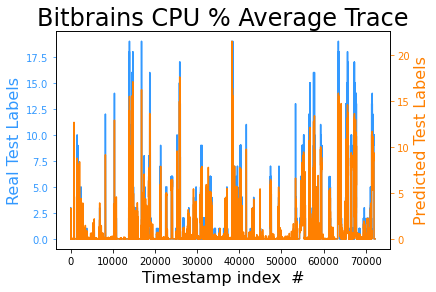

In [80]:
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels

color_one = '#3399FF'
color_two = '#FF8000'

fig, ax1 = plt.subplots()

t = np.arange(0, test_data.shape[0])
ax1.plot(t, testY.reshape(-1,1), color=color_one)
ax1.set_xlabel('Timestamp index  #', )
ax1.set_ylabel('Real Test Labels', color=color_one)
ax1.tick_params('y', colors=color_one)

ax2 = ax1.twinx()
ax2.plot(t, testPredict, color=color_two)
ax2.set_ylabel('Predicted Test Labels', color=color_two)
ax2.tick_params('y', colors=color_two)

plt.title("Bitbrains CPU % Average Trace", fontsize=24)

plt.show()

In [76]:
testPredict

array([[ 2.85685396],
       [ 2.65646005],
       [ 3.34290552],
       ...,
       [-0.05693924],
       [-0.05918327],
       [-0.06078461]])

In [78]:
for i in range(len(testPredict)):
    if testPredict[i] < 0 : 
        testPredict[i] = 0

In [79]:
testPredict

array([[2.85685396],
       [2.65646005],
       [3.34290552],
       ...,
       [0.        ],
       [0.        ],
       [0.        ]])